In [1]:
import pandas as pd

## Загружаем данные

In [2]:
data_dir = '../data/random_data'

In [3]:
tracks = pd.read_csv('{}/tracks.csv'.format(data_dir), index_col=0)
artists = pd.read_csv('{}/artists.csv'.format(data_dir), index_col=0)
albums = pd.read_csv('{}/albums.csv'.format(data_dir), index_col=0)
transactions = pd.read_csv('{}/transactions.csv'.format(data_dir), index_col=0)
playlists = pd.read_csv('{}/playlists.csv'.format(data_dir), index_col=0)

К каждой транзакции добавляем признаки популярность(popular), артист(artistid), альбом(albumid) трека, имя плейлиста(name), num_followers плейлиста

In [4]:
def get_full_dataset(transactions, tracks, playlists):
    full_dataset = pd.merge(transactions, tracks, how='left', on='trackid')
    full_dataset = pd.merge(full_dataset, playlists, how='left', on='pid')
    return full_dataset

Рейтинг определяем единичкой

In [5]:
full_dataset = get_full_dataset(transactions, tracks, playlists)
full_dataset['rating'] = 1
full_dataset.head()

,pid,trackid,popular,artistid,albumid,name,num_followers,rating
0,822032,2283,3384,1151,1618,party time,1,1
1,822032,2288,4339,1152,1622,party time,1,1
2,822032,907,4992,500,687,party time,1,1
3,822032,896,5309,495,677,party time,1,1
4,822032,901,3481,495,681,party time,1,1


In [6]:
full_dataset.shape

(72955, 8)

Импортируем основные модули

In [7]:
from polara.recommender.models import RecommenderModel
from polara.recommender.data import RecommenderData
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from scipy import sparse
from polara.recommender.coldstart.data import ItemColdStartData
from polara.recommender.models import SVDModel

### Описания модели

- $\textbf{R}$ - матрица playlist-track
- $\textbf{X}$ - матрица playlist-feuture
- $\textbf{A}$ - матрица близости плейлистов
- $\textbf{D}$ - диагональная матрица суммы строк $\textbf{A}$
- $\textbf{L} = D - A$ - лапласиан

$$J = \frac{1}{2}[\alpha||\textbf{R} - \textbf{UV}||_F^2 + (1 - \alpha)||\textbf{X} - \textbf{UH}||_F^2 + \beta Tr(\textbf{U}^T\textbf{LU}) + \lambda(||\textbf{U}||_F^2 + ||\textbf{V}||_F^2 + ||\textbf{H}||_F^2]$$

$$arg \min_{\textbf{U}, \textbf{V}, \textbf{H}} J$$
$$s.t. U \geq 0, V \geq 0, H \geq 0$$

Обновление $\textbf{U}, \textbf{V} , \textbf{H}$:

- $$U = U * \frac{\alpha\textbf{R}\textbf{V}^T + (1 -\alpha)\textbf{X}\textbf{H}^T + \beta\textbf{AU}}{\alpha\textbf{UV}\textbf{V}^T + (1 - \alpha)\textbf{UH}\textbf{H}^T + \beta\textbf{DU} + \lambda\textbf{U}}$$
- $$V = V * \frac{\alpha\textbf{U}^T\textbf{R}}{\alpha\textbf{U}^T\textbf{UV} + \lambda\textbf{V}}$$
- $$H = H * \frac{(1 - \alpha)\textbf{U}^T\textbf{X}}{(1 - \alpha)\textbf{U}^T\textbf{UH} + \lambda\textbf{H}}$$

$*$ - поэлементное умножение
$\frac{\dots}{\dots}$ - поэлементное деление

### Класс LocalCollectiveEmbeddings

- get_train_content - получить признаки транзакций, content_data - df с признаками
- get_content_shape - возвращает количество столбцов для каждого признака
- get_training_content_matrix - возвращает матрицу features $n \times v$ где n - кол-во плейлистов, v - количество признаков
- get_test_content_matrix - аналогично для тестовой выборки
- construct_closeness_matrix - строит матрицу близости плейлистов для по признакому описанию
- update_factors - обновляет матрицы U, V, H по правилам выше
- build - возвращает матрицу факторов плейлистов, треков, признаков
    - аргументы df с признаками, параметры модели, maxiter, verbose

In [8]:
class LocalCollectiveEmbeddings(RecommenderModel):
    import scipy.sparse
    
    def __init__(self, *args, **kwargs):
        super(LocalCollectiveEmbeddings, self).__init__(*args, **kwargs)
        self.method = 'LCE'
    
    def get_train_content(self, content_data):
        self.train_content = content_data
    
    def get_content_shape(self):
        self.content_shape = {}
        for col in self.train_content.columns:
            self.content_shape[col] = self.train_content[col].max() + 1

    def get_training_content_matrix(self):
        self.get_content_shape()
        idx_userid = self.data.training[self.data.fields[0]].values
        val = np.ones(self.data.training.shape[0])
        
        i = 0
        features = []
        
        for col in self.train_content.columns:
            idx_feature = self.train_content[col].values
            shp = (idx_userid.max() + 1, 
                   self.content_shape[col])
        
            features_new = sparse.csr_matrix((val, (idx_userid, idx_feature)), 
                                             shape=shp)
            
            if i == 0:
                features = features_new
            else:
                features = sparse.hstack((features, features_new))
            
            i += 1
        
        return features
    
    def get_test_content_matrix(self):
        idx_userid = self.data.test.testset[self.data.fields[0]].values
        val = np.ones(self.data.test.testset.shape[0])
        
        i = 0
        features = []
        
        for col in self.train_content.columns:
            idx_feature = self.data.test.testset[col].values
            shp = (idx_userid.max() + 1, 
                   self.content_shape[col])
        
            features_new = sparse.csr_matrix((val, (idx_userid, idx_feature)), 
                                             shape=shp)
            
            if i == 0:
                features = features_new
            else:
                features = sparse.hstack((features, features_new))
            
            i += 1
        
        
        return features
        
        
    def construct_closeness_matrix(self, X, rank, binary=False):
        print ('Construct closeness matrix...')
        nbrs = NearestNeighbors(n_neighbors=1 + rank).fit(X)
        if binary:
            closeness_matrix = nbrs.kneighbors_graph(X)
        else:
            closeness_matrix = nbrs.kneighbors_graph(X, mode='distance')
        print ('Done.')
            
        return closeness_matrix
    
    def get_constant(self, R, X):
        trRtR = tr(R, R)
        trXtX = tr(X, X)
        return trRtR, trXtX
    
    def update_factors(self, R, X, U, V, H, A, D, 
                       alpha, beta, lamb):
        
        gamma = 1. - alpha
        
        UtU = U.T.dot(U)
        UtR = U.T.dot(R)
        UtX = U.T.dot(X)
        UtUV = UtU.dot(V)
        UtUH = UtU.dot(H)
        DU = D.dot(U)
        AU = A.dot(U)
        
        #update V
        V_1 = np.divide((alpha * UtR), 
                        (alpha * UtUV + lamb * V).maximum(1e-10))
        V = V.multiply(V_1)
            
        #update H
        H_1 = np.divide(
            (gamma * UtX), (gamma * UtUH + lamb * H).maximum(1e-10))
        H = H.multiply(H_1)
            
        # update U
        U_t1 = alpha * R.dot(V.T) + gamma * X.dot(H.T) + beta * AU
        U_t2 = alpha * U.dot(V.dot(V.T)) + gamma * \
        U.dot(H.dot(H.T)) + beta * DU + lamb * U
            
        U_t3 = np.divide(U_t1, (U_t2).maximum(1e-10))
        U = U.multiply(U_t3)
        
        #calculate oblective function without constant
        
        tr1 = alpha * ((-2.) * tr(V, UtR) + tr(V, UtUV))
        tr2 = gamma * ((-2.) * tr(H, UtX) + tr(H, UtUH))
        tr3 = beta * (tr(U, DU) - tr(U, AU))
        tr4 = lamb * (UtU.diagonal().sum() + tr(V, V) + tr(H, H))

        Obj = tr1 + tr2 + tr3 + tr4
        
        
        return U, V, H, Obj
        
        
        
    def build(self, content_data, 
              rank=10, alpha=0.1, beta=0.005, lamb=0.0001, 
              epsilon=0.01, seed=0,maxiter=150, verbose=True):
        
        self.get_train_content(content_data)
        
        R = self.get_training_matrix(dtype='float64')
        X = self.get_training_content_matrix()
        A = self.construct_closeness_matrix(X, rank, binary=True).tocsr()
        
        num_users = R.shape[0]
        num_items = R.shape[1]
        num_features = X.shape[1]
        
        U = np.abs(sparse.rand(num_users, rank, 0.99, 'csr', dtype=R.dtype, random_state=seed))
        V = np.abs(sparse.rand(rank, num_items, 0.99, 'csr', dtype=R.dtype, random_state=seed))
        H = np.abs(sparse.rand(rank, num_features, 0.99, 'csr', dtype=R.dtype, random_state=seed))
        
        
        #auxiliary constant   
        D = sparse.dia_matrix((A.sum(axis=0), 0), A.shape)
        trRtR, trXtX = self.get_constant(R, X)

        itNum = 1
        delta = 2.0 * epsilon

        ObjHist = []
        
        while True:

            U, V, H, Obj = self.update_factors(R, X, U, V, H, A, D, 
                                               alpha, beta, lamb)
            Obj += alpha*trRtR + (1. - alpha)*trXtX
            Obj = Obj / (num_users * num_features * num_items * rank)
            ObjHist.append(Obj)
            
            if itNum > 1:
                delta = abs(ObjHist[-1] - ObjHist[-2])
                if verbose:
                    print ("Iteration: ", itNum, "Objective: ", Obj, "Delta: ", delta)
                if itNum > maxiter or delta < epsilon:
                    break

            itNum += 1
            
        self.user_factors = U
        self.feature_factors = H 
        self.item_factors = V
        
        
    def slice_recommendations(self, test_data, shape, start, stop, test_users=None):
        slice_data = self._slice_test_data(test_data, start, stop)
        features = self.get_test_content_matrix()
        Ut = np.linalg.lstsq(self.feature_factors.T.toarray(), 
                             features.T.toarray(), rcond=-1)[0]
        R = Ut.T.dot(self.item_factors.toarray())
        return R, slice_data

In [9]:
def reindex_content(content_data, col, sort=True, inplace=True):
    grouper = content_data.groupby(col, sort=sort).grouper
    new_val = grouper.group_info[1]
    old_val = grouper.levels[0]
    val_transform = pd.DataFrame({'old': old_val, 'new': new_val})
    new_data = grouper.group_info[0]

    if inplace:
        result = val_transform
        content_data.loc[:, col] = new_data
    else:
        result = (new_data, val_transform)
    return result
        
def reindex_content_columns(content_data, columns):
    index_content = {}
    for col in columns:
        index_content[col] = reindex_content(content_data, col)
    return index_content

In [10]:
def tr(A, B):
    x = A.multiply(B)
    return (x.sum(axis=0)).sum(axis=1)

In [11]:
def cross_validation_lce(data, n_splits=5, seed=1, test_size=0.05, 
                         topk=500, rank=10, maxiter=10000, epsilon=0.1, 
                         alpha=.9, lamb=0.001, beta=0.05):
    
    index_content = reindex_content_columns(data, ['artistid', 'albumid'])
    
    kf = KFold(n_splits=n_splits, random_state=seed)
    i = 1
    scores_lce = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    scores_svd = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    for users_ids, unseen_users_ids in kf.split(data['pid'].drop_duplicates()):
        print('=========================Fold {}============================='.format(i))
        i += 1
        users = data['pid'].drop_duplicates().values[users_ids]
        unseen_users = data['pid'].drop_duplicates().values[unseen_users_ids]
        train = data.query('pid in @users')
        test = data.query('pid in @unseen_users')
        train_albums = train.albumid.unique()
        train_artists = train.artistid.unique()
        test = test.query('albumid in @train_albums')
        test = test.query('artistid in @train_artists')
        test_sampled = test.sample(frac=1-test_size, random_state=seed).sort_values('pid')
        test_holdout = test[~test.index.isin(test_sampled.index)]
        
        data_model = RecommenderData(train,'pid', 'trackid', 'rating', seed=seed)
        data_model.prepare_training_only()
        lce = LocalCollectiveEmbeddings(data_model)
        lce.build(train[['artistid', 'albumid']], verbose=False, 
                  rank=rank, maxiter=maxiter, 
                  alpha=alpha, epsilon=epsilon, beta=beta, lamb=lamb)
        
        svd = SVDModel(data_model)
        svd.rank = rank
        svd.build()
        
        data_model.set_test_data(testset=test_sampled, holdout=test_holdout, warm_start=True)
        lce.topk = topk
        lce.swith_positive = 1
        
        svd.topk = topk
        svd.swith_positive = 1
        
        hits = lce.evaluate()
        relevance = lce.evaluate('relevance')
        ranking = lce.evaluate('ranking')
        
        scores_lce['precision'].append(relevance.precision)
        scores_lce['recall'].append(relevance.recall)
        scores_lce['miss_rate'].append(relevance.miss_rate)
        scores_lce['nDCG'].append(ranking.nDCG)
        
        print('lce hits', hits)
        
        hits = svd.evaluate()
        relevance = svd.evaluate('relevance')
        ranking = svd.evaluate('ranking')        
        
        scores_svd['precision'].append(relevance.precision)
        scores_svd['recall'].append(relevance.recall)
        scores_svd['miss_rate'].append(relevance.miss_rate)
        scores_svd['nDCG'].append(ranking.nDCG)
        
        print ('svd hits', hits)
        
    result_lce = pd.DataFrame(scores_lce)
    result_svd = pd.DataFrame(scores_svd)
    return result_lce, result_svd

In [12]:
import tqdm

In [13]:
ranks = [5, 10, 15, 25, 50]
recall_lce, recall_svd = [], []
nDCG_lce, nDCG_svd = [], []
precision_lce, precision_svd  = [], []
miss_rate_lce, miss_rate_svd= [], []
for rank in tqdm.tqdm(ranks):
    print('             ===========rank={}============='.format(rank))
    result_lce, result_svd = cross_validation_lce(full_dataset,n_splits=5, topk=10, test_size=0.1, 
                                                  rank=rank, alpha=0.9, epsilon=1e-11, 
                                                  lamb=1, beta=0.05)
    recall_lce.append(result_lce.recall.mean())
    nDCG_lce.append(result_lce.nDCG.mean())
    precision_lce.append(result_lce.precision.mean())
    miss_rate_lce.append(result_lce.miss_rate.mean())
    recall_svd.append(result_svd.recall.mean())
    nDCG_svd.append(result_svd.nDCG.mean())
    precision_svd.append(result_svd.precision.mean())
    miss_rate_svd.append(result_svd.miss_rate.mean())

  0%|          | 0/5 [00:00<?, ?it/s]

             ===========rank=5=============
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


PureSVD training time: 0.02512047698837705s
33 unique trackid's within 36 testset interactions were filtered. Reason: not in the training data.
5 unique trackid's within 5 holdout interactions were filtered. Reason: not in the training data.
171 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=142, false_positive=4738, true_negative=None, false_negative=1276)
svd hits Hits(true_positive=158, false_positive=4722, true_negative=None, false_negative=1260)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
PureSVD training time: 0.027114024007460102s
27 unique trackid's within 30 testset interactions were filtered. Reason: not in the training data.
3 unique trackid's within 3 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
152 pid's were filtered out from testset. Reason: in

 20%|██        | 1/5 [00:20<01:21, 20.36s/it]

lce hits Hits(true_positive=124, false_positive=4966, true_negative=None, false_negative=1317)
svd hits Hits(true_positive=152, false_positive=4938, true_negative=None, false_negative=1289)
             ===========rank=10=============
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
PureSVD training time: 0.03371043998049572s
33 unique trackid's within 36 testset interactions were filtered. Reason: not in the training data.
5 unique trackid's within 5 holdout interactions were filtered. Reason: not in the training data.
171 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=173, false_positive=4707, true_negative=None, false_negative=1245)
svd hits Hits(true_positive=208, false_positive=4672, true_negative=None, false_negative=1210)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
PureSVD traini

 40%|████      | 2/5 [00:50<01:15, 25.16s/it]

lce hits Hits(true_positive=146, false_positive=4944, true_negative=None, false_negative=1295)
svd hits Hits(true_positive=199, false_positive=4891, true_negative=None, false_negative=1242)
             ===========rank=15=============
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
PureSVD training time: 0.16532025401829742s
33 unique trackid's within 36 testset interactions were filtered. Reason: not in the training data.
5 unique trackid's within 5 holdout interactions were filtered. Reason: not in the training data.
171 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=204, false_positive=4676, true_negative=None, false_negative=1214)
svd hits Hits(true_positive=254, false_positive=4626, true_negative=None, false_negative=1164)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
PureSVD traini

 60%|██████    | 3/5 [01:27<00:58, 29.22s/it]

lce hits Hits(true_positive=147, false_positive=4943, true_negative=None, false_negative=1294)
svd hits Hits(true_positive=241, false_positive=4849, true_negative=None, false_negative=1200)
             ===========rank=25=============
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
PureSVD training time: 0.09632662899093702s
33 unique trackid's within 36 testset interactions were filtered. Reason: not in the training data.
5 unique trackid's within 5 holdout interactions were filtered. Reason: not in the training data.
171 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=229, false_positive=4651, true_negative=None, false_negative=1189)
svd hits Hits(true_positive=318, false_positive=4562, true_negative=None, false_negative=1100)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
PureSVD traini

 80%|████████  | 4/5 [02:30<00:37, 37.68s/it]

lce hits Hits(true_positive=213, false_positive=4877, true_negative=None, false_negative=1228)
svd hits Hits(true_positive=285, false_positive=4805, true_negative=None, false_negative=1156)
             ===========rank=50=============
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
PureSVD training time: 0.24990174898994155s
33 unique trackid's within 36 testset interactions were filtered. Reason: not in the training data.
5 unique trackid's within 5 holdout interactions were filtered. Reason: not in the training data.
171 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=251, false_positive=4629, true_negative=None, false_negative=1167)
svd hits Hits(true_positive=346, false_positive=4534, true_negative=None, false_negative=1072)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
PureSVD traini

100%|██████████| 5/5 [04:50<00:00, 58.15s/it]

lce hits Hits(true_positive=231, false_positive=4859, true_negative=None, false_negative=1210)
svd hits Hits(true_positive=316, false_positive=4774, true_negative=None, false_negative=1125)


In [14]:
import matplotlib.pyplot as plt

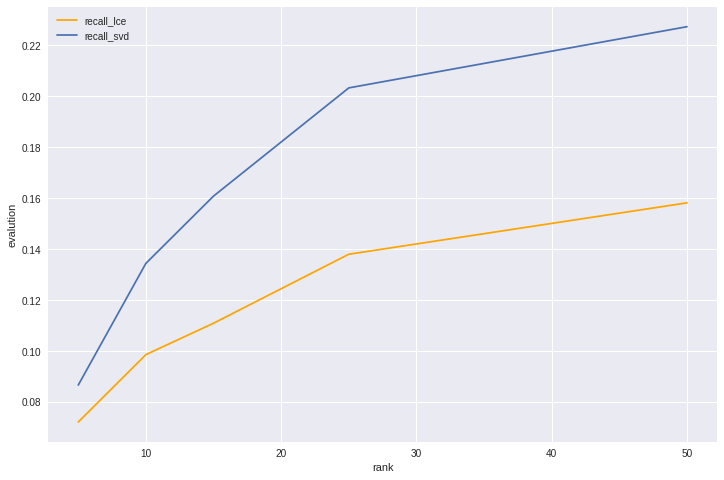

In [15]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(ranks, recall_lce, 'orange', label='recall_lce')
plt.plot(ranks, recall_svd, label='recall_svd')
plt.ylabel('evalution')
plt.xlabel('rank')
plt.legend()
plt.show()

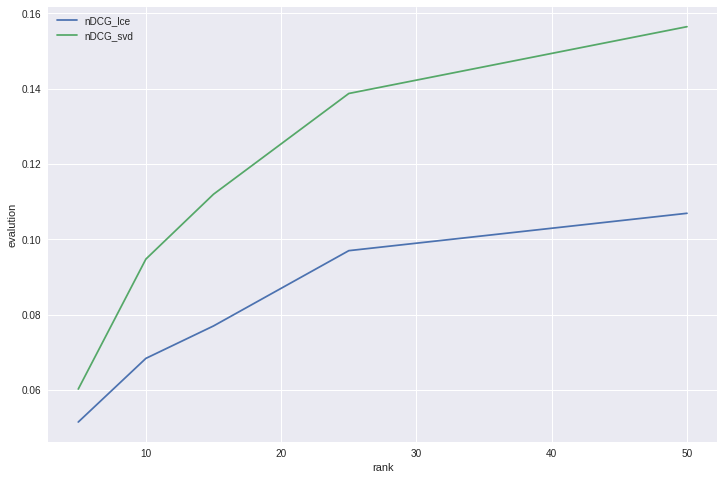

In [16]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(ranks, nDCG_lce,label='nDCG_lce')
plt.plot(ranks, nDCG_svd, label='nDCG_svd')
plt.ylabel('evalution')
plt.xlabel('rank')
plt.legend()
plt.show()